### (NTP) Network Transportation Problem
- Find the shipment patterns from supply points to demand points such that all demands are satisfied and the total cost is minimized.
- Sets:
    - $I$: set of suppliers
    - $J$: set of demand points
- Parameters:
    - $c_{ij}$: unit cost of shipping from supply node $i\in I$ to demand node $j\in J$
    - $S_i$: supply at node $i\in I$
    - $D_j$: demand node at $j\in J$
- Decision variables:
    - $X_{ij}=$ the amount shipped from supply node $i\in I$ to demand node $j\in J$

<br>

$$
\begin{split}
\text{(NTP)}\quad & \text{minimize}\quad \sum\limits_{i\in I}\sum\limits_{j\in J}c_{ij}X_{ij}\\
&\begin{split}
\text{subject to}\quad\quad \sum\limits_{j\in J}&X_{ij}\le S_{i} &\forall i\in I\\
   \sum\limits_{i\in I}&X_{ij}\ge D_{j} \quad\quad&\forall j\in J\\
                       &X_{ij}\ge 0     &\forall i\in I, \forall j\in J\\ 
\end{split}
\end{split}
$$

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from statistics import mean
from scipy import stats
from gurobipy import Model, GRB, quicksum
%matplotlib inline

In [2]:
# settings
sns.reset_orig
sns.set_style('darkgrid')
sns.set_palette('Set1')

np.set_printoptions(linewidth=200)

In [3]:
# import data
i_data = pd.read_excel('data.xlsx', sheet_name='i_data')
j_data = pd.read_excel('data.xlsx', sheet_name='j_data')
dist_ij = pd.read_excel('data.xlsx', sheet_name='dist_ij').values

In [4]:
# declare the parameters and sets
S = i_data['Supply'].values
D = j_data['Demand'].values

I = [i for i in range(len(S))]
J = [j for j in range(len(D))]
A = [(i, j) for i in I for j in J]

cost = 2
c = {(i, j): dist_ij[i, j]*2 for (i, j) in A}

In [5]:
# create model
mdl = Model('NTP')

Academic license - for non-commercial use only - expires 2022-08-28
Using license file C:\Users\jack4\gurobi.lic


In [6]:
# add model variables
X = mdl.addVars(A)

In [7]:
# add objective function
mdl.ModelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(c[i,j]*X[i,j] for i,j in A))

In [8]:
# add the model constraints
mdl.addConstrs(quicksum(X[i,j] for j in J) <= S[i] for i in I)
mdl.addConstrs(quicksum(X[i,j] for i in I) >= D[j] for j in J)
mdl.addConstrs(X[i,j] >= 0 for i,j in A)
mdl.update()

In [9]:
%%time

# optimize
mdl.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 34 rows, 24 columns and 72 nonzeros
Model fingerprint: 0x62d53ee1
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 5e+02]
Presolve removed 24 rows and 0 columns
Presolve time: 0.00s
Presolved: 10 rows, 24 columns, 48 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.937500e+01   0.000000e+00      0s
       6    1.2989607e+04   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.00 seconds
Optimal objective  1.298960672e+04
Wall time: 6.98 ms


In [10]:
# get amount shipped to each location
shipped = {(i,j): X[i,j].X for i,j in A if X[i,j].X > 0}
shipped

{(0, 2): 53.0,
 (1, 3): 76.0,
 (1, 4): 86.0,
 (2, 0): 81.0,
 (3, 1): 80.0,
 (3, 5): 99.0}

Text(0.5, 1.0, 'Demand Coverage')

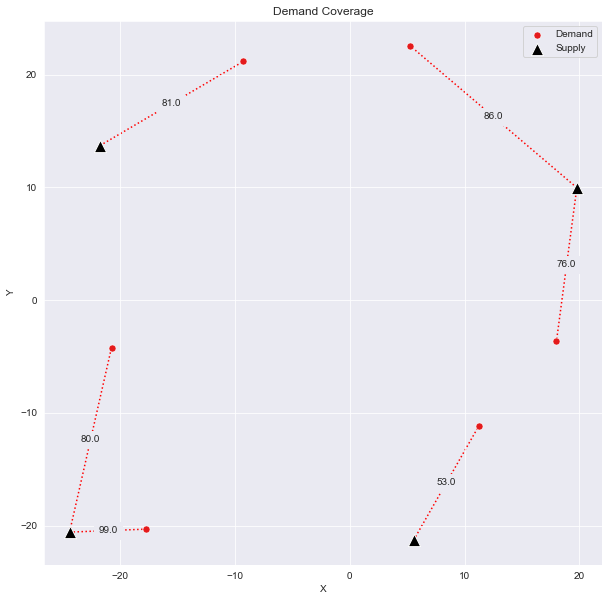

In [11]:
# plot the coverage
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='X', y='Y', data=j_data, s=50, legend=False, label="Demand")
sns.scatterplot(x='X', y='Y', data=i_data, s=150, color='black', marker='^', label="Supply")

for path, nb in shipped.items():
    point1 = [i_data['X'][path[0]], i_data['Y'][path[0]]]
    point2 = [j_data['X'][path[1]], j_data['Y'][path[1]]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    
    plt.plot(x_values, y_values, 'r', linestyle=":", zorder=0)
    plt.text(
        mean(x_values), mean(y_values), str(nb), backgroundcolor='#eaeaf2',
        horizontalalignment='center', verticalalignment='center'
    )

plt.title('Demand Coverage')

In [12]:
# find objective value
print('Objective value =', sum(c[a]*X[a].X for a in A))

Objective value = 12989.606720211896
